In [39]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Dataset kök qovluğu
base_dir = "PlantDiseasesDataset"
output_dir = "ProcessedDataset"
train_dir = os.path.join(output_dir, "train")
valid_dir = os.path.join(output_dir, "valid")

for dir_path in [train_dir, valid_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Minimum şəkil sayı
MIN_IMAGES = 5

# Uyğun fayl uzantıları (case-insensitive)
valid_extensions = (".jpg", ".png", ".jpeg", ".JPG", ".PNG", ".JPEG")

for plant_folder in os.listdir(base_dir):
    plant_path = os.path.join(base_dir, plant_folder)
    if not os.path.isdir(plant_path):
        continue

    # Hər bir class üçün train və valid fayllarını birləşdirib yoxlayırıq
    all_classes = {}
    for data_type in ["train", "valid"]:
        data_type_path = os.path.join(plant_path, data_type)
        if not os.path.isdir(data_type_path):
            print(f"{data_type_path} qovluğu mövcud deyil!")
            continue

        for class_folder in os.listdir(data_type_path):
            class_path = os.path.join(data_type_path, class_folder)
            if not os.path.isdir(class_path):
                continue

            # Şəkilləri topla
            images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(valid_extensions)]
            if class_folder not in all_classes:
                all_classes[class_folder] = []
            all_classes[class_folder].extend(images)

    # Şəkilləri işləyirik
    for class_folder, images in all_classes.items():
        image_count = len(images)
        print(f"Processing class: {class_folder}, Found images: {image_count}")

        # Əgər şəkillərin sayı azdırsa
        if image_count < MIN_IMAGES:
            print(f"Class {class_folder} has less than {MIN_IMAGES} images. Assigning all to train.")
            train_output_path = os.path.join(train_dir, class_folder)
            os.makedirs(train_output_path, exist_ok=True)
            for img in images:
                shutil.copy(img, train_output_path)
            continue

        # Normal bölüşdürmə
        train_images, valid_images = train_test_split(images, test_size=0.2, random_state=42)

        train_output_path = os.path.join(train_dir, class_folder)
        os.makedirs(train_output_path, exist_ok=True)
        for img in train_images:
            shutil.copy(img, train_output_path)

        valid_output_path = os.path.join(valid_dir, class_folder)
        os.makedirs(valid_output_path, exist_ok=True)
        for img in valid_images:
            shutil.copy(img, valid_output_path)

print("Dataset uğurla train/validation bölmələrinə ayrıldı!")


Processing class: Apple Black rot, Found images: 3107
Processing class: Apple Healthy, Found images: 4245
Processing class: Apple Scab, Found images: 3245
Processing class: Cedar apple rust, Found images: 2567
Processing class: Bell pepper Bacterial spot, Found images: 3460
Processing class: Bell pepper Healthy, Found images: 4024
Processing class: Cherry Healthy, Found images: 3194
Processing class: Cherry Powdery mildew, Found images: 3158
Processing class: Corn Common rust, Found images: 3695
Processing class: Corn Gray leaf spot, Found images: 2635
Processing class: Corn Healthy, Found images: 3488
Processing class: Corn Northern Leaf Blight, Found images: 3562
Processing class: Grape Black Measles, Found images: 3786
Processing class: Grape Black rot, Found images: 3607
Processing class: Grape Healthy, Found images: 2610
Processing class: Grape Isariopsis Leaf Spot, Found images: 3231
Processing class: Peach Bacterial spot, Found images: 4596
Processing class: Peach Healthy, Found

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Dataset yolunu təyin edin
train_dir = r"C:\Users\user\Desktop\Technofest Project\ProcessedDataset\train"
valid_dir = r"C:\Users\user\Desktop\Technofest Project\ProcessedDataset\valid"

# Şəkillərin ölçüsünü və batch size təyin edin
img_size = (224, 224)
batch_size = 16  
# Dataset generatorları
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# InceptionV3 baza modeli
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

# Model arxitekturası
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout ilə overfitting-i azaldırıq
output = Dense(
    train_generator.num_classes, 
    activation="softmax", 
    kernel_regularizer=l2(0.01)  # Regularization əlavə olunur
)(x)

model = Model(inputs=base_model.input, outputs=output)

# Modeli kompilyasiya edin
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1
)

# Təlim
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Baza modeli açaraq tam öyrətmə (fine-tuning)
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Modeli saxlayın
model.save("inceptionv3_model_finetuned.h5")


Found 94509 images belonging to 33 classes.
Found 23674 images belonging to 33 classes.
Epoch 1/10


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5907/5907 ━━━━━━━━━━━━━━━━━━━━ 8937s 2s/step - accuracy: 0.3569 - loss: 2.9715 - val_accuracy: 0.7583 - val_loss: 1.3893 - learning_rate: 1.0000e-04
Epoch 2/10
5907/5907 ━━━━━━━━━━━━━━━━━━━━ 2055s 348ms/step - accuracy: 0.6929 - loss: 1.4841 - val_accuracy: 0.7894 - val_loss: 1.1953 - learning_rate: 1.0000e-04
Epoch 3/10
5907/5907 ━━━━━━━━━━━━━━━━━━━━ 1889s 320ms/step - accuracy: 0.7323 - loss: 1.2996 - val_accuracy: 0.7942 - val_loss: 1.1386 - learning_rate: 1.0000e-04
Epoch 4/10
5907/5907 ━━━━━━━━━━━━━━━━━━━━ 5707s 966ms/step - accuracy: 0.7406 - loss: 1.2505 - val_accuracy: 0.7983 - val_loss: 1.1228 - learning_rate: 1.0000e-04
Epoch 5/10
5907/5907 ━━━━━━━━━━━━━━━━━━━━ 3671s 621ms/step - accuracy: 0.7441 - loss: 1.2407 - val_accuracy: 0.8006 - val_loss: 1.1209 - learning_rate: 1.0000e-04
Epoch 6/10
5907/5907 ━━━━━━━━━━━━━━━━━━━━ 2062s 349ms/step - accuracy: 0.7440 - loss: 1.2358 - val_accuracy: 0.8013 - val_loss: 1.1201 - learning_rate: 1.0000e-04
Epoch 7/10
5907/5907 ━━━━━━━━━━━━━━━

In [72]:
model.save('my_model.keras')


In [73]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Modeli yükləyin
model = tf.keras.models.load_model(r"C:\Users\user\Desktop\Technofest Project\my_model.keras")

# Sinif adları
class_labels = [
    "Apple Black rot",
    "Apple Healthy",
    "Apple Scab",
    "Cedar apple rust",
    "Bell pepper Bacterial spot",
    "Bell pepper Healthy",
    "Cherry Healthy",
    "Cherry Powdery mildew",
    "Corn Common rust",
    "Corn Gray leaf spot",
    "Corn Healthy",
    "Corn Northern Leaf Blight",
    "Grape Black Measles",
    "Grape Black rot",
    "Grape Healthy",
    "Grape Isariopsis Leaf Spot",
    "Peach Bacterial spot",
    "Peach Healthy",
    "Potato Early blight",
    "Potato Healthy",
    "Potato Late blight",
    "Strawberry Healthy",
    "Strawberry Leaf scorch",
    "Tomato Bacterial spot",
    "Tomato Early blight",
    "Tomato Healthy",
    "Tomato Late blight",
    "Tomato Leaf Mold",
    "Tomato Mosaic virus",
    "Tomato Septoria leaf spot",
    "Tomato Spider mites",
    "Tomato Target Spot",
    "Tomato Yellow Leaf Curl Virus"
]

def predict_image_class(image_path):
    image_size = (224, 224)  # Modelin qəbul etdiyi şəkil ölçüsü
    
    # Şəkili yükləyin və emal edin
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normalizasiya
    img_array = np.expand_dims(img_array, axis=0)  # Model üçün genişləndirin

    # Modeldən proqnoz alın
    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label




C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 192 variables whereas the saved optimizer has 382 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [78]:
# Şəkilin yolunu göstərin
image_path = r"C:\Users\user\Desktop\Technofest Project\test\AppleCedarRust4.JPG"

# Proqnozu alın
predicted_class = predict_image_class(image_path)
print(f"Şəkil: {image_path}")
print(f"Proqnozlaşdırılmış sinif: {predicted_class}")

Şəkil: C:\Users\user\Desktop\Technofest Project\test\AppleCedarRust4.JPG
Proqnozlaşdırılmış sinif: Cedar apple rust


1480/1480 ━━━━━━━━━━━━━━━━━━━━ 521s 352ms/step


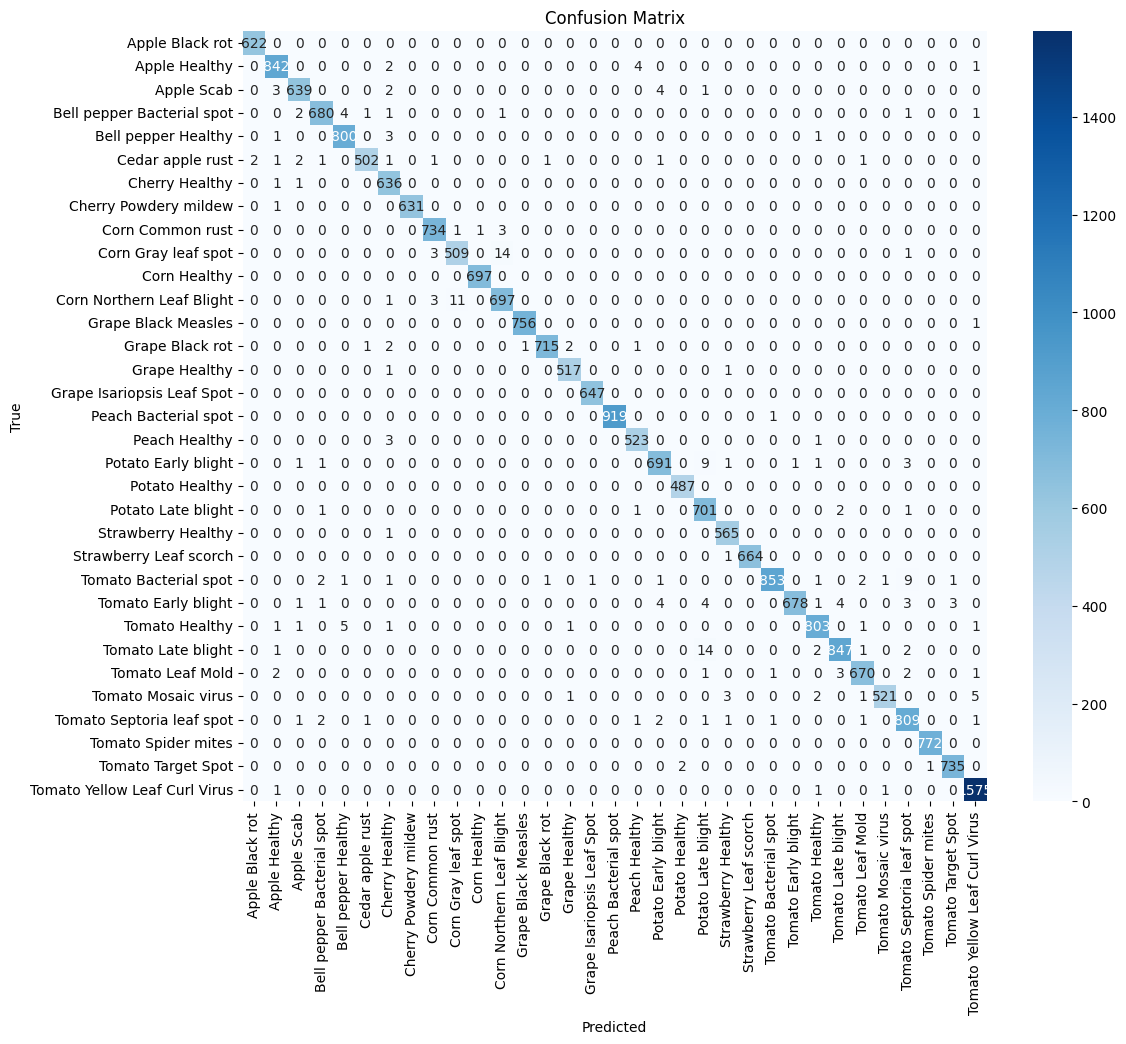

                               precision    recall  f1-score   support

              Apple Black rot       1.00      1.00      1.00       622
                Apple Healthy       0.99      0.99      0.99       849
                   Apple Scab       0.99      0.98      0.99       649
   Bell pepper Bacterial spot       0.99      0.98      0.99       691
          Bell pepper Healthy       0.99      0.99      0.99       805
             Cedar apple rust       0.99      0.98      0.99       513
               Cherry Healthy       0.97      1.00      0.98       638
        Cherry Powdery mildew       1.00      1.00      1.00       632
             Corn Common rust       0.99      0.99      0.99       739
          Corn Gray leaf spot       0.98      0.97      0.97       527
                 Corn Healthy       1.00      1.00      1.00       697
    Corn Northern Leaf Blight       0.97      0.98      0.98       712
          Grape Black Measles       1.00      1.00      1.00       757
     

In [77]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Validation generatorun bütün şəkillər üçün proqnozlar alırıq

valid_generator.reset()
y_pred_probs = model.predict(valid_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Validation generatorun doğru etiketlərini götürürük

y_true = valid_generator.classes  # Bu valid_generator-da etiketlərdir

# 3. Sinif adları

class_labels = list(valid_generator.class_indices.keys())

# 4. Confusion Matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 5. Classification Report (precision, recall, f1-score)

print(classification_report(y_true, y_pred, target_names=class_labels))

# 6. Sinif balansı (validation datasında)

class_counts = Counter(y_true)
print("Validation setində siniflərin paylanması:")
for cls_index, count in class_counts.items():
    print(f"{class_labels[cls_index]}: {count} nümunə")

# 7. Səhv proqnozların sayı

incorrect_indices = np.where(y_true != y_pred)[0]
print(f"Səhv təyin edilmiş nümunələrin sayı: {len(incorrect_indices)}")
